In [410]:
from tensorflow import keras
import cv2
from skimage.io import imread, imshow
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from torchvision import transforms
import os

In [411]:
model = keras.models.load_model(r"C:\Users\Anton\Google Drive\main\programming\tikwatermeters\U-net Checkpoints\unet.h5")

H: 1333, W: 1000


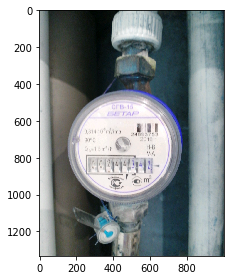

In [412]:
images_data = []
img_path = r"C:\Users\Anton\Downloads\TlkWaterMeters\presentation\original1.jpg"
img = cv2.imread(img_path)
print(f'H: {len(img)}, W: {len(img[0])}')
imshow(img)
img = cv2.resize(img, (128, 128))
images_data.append(img)
images_data = np.array(images_data, dtype=np.uint8)

In [413]:
x = 0.6083725597673628
mask = model.predict(images_data, verbose=1)
mask = (mask > x).astype(np.uint8)

1/1 [==============================] - 0s 268ms/step


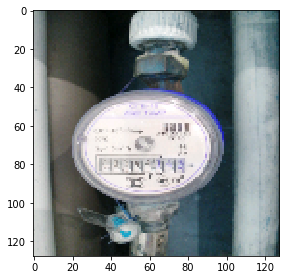

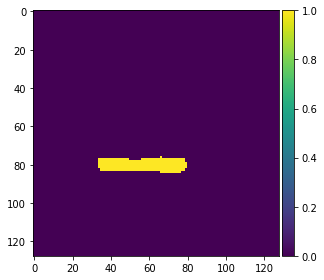

In [414]:
imshow(img)
plt.show()
imshow(np.squeeze(mask))
plt.show()

In [415]:
def crop(img, bg, mask):
    fg = cv2.bitwise_or(img, img, mask=mask) 
    fg_back_inv = cv2.bitwise_or(bg, bg, mask=cv2.bitwise_not(mask))
    
    return cv2.bitwise_or(fg, fg_back_inv)

In [416]:
cropped_path = r"C:\Users\Anton\Downloads\TlkWaterMeters\presentation\cropped.jpg"

In [417]:
img = cv2.imread(img_path)
h, w, _ = img.shape
mask = cv2.resize(np.squeeze(mask), (w, h))
bg = np.zeros_like(img, 'uint8')
new_image = crop(img,bg,mask)
new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)

where = np.array(np.where(new_image))
x1, y1, z1 = np.amin(where, axis=1)
x2, y2, z2 = np.amax(where, axis=1)
sub_image = new_image.astype('uint8')[x1:x2, y1:y2]

cv2.imwrite(cropped_path, sub_image)

True

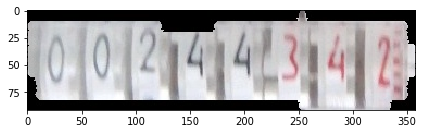

In [418]:
img = cv2.imread(cropped_path)
imshow(img)

In [419]:
class CNN(nn.Module):
    def __init__(self, output_size=100, dropout=0.5):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(1, 32, kernel_size=5, stride=2, padding=1),
                                  nn.ReLU(inplace=True),
                                  nn.MaxPool2d(kernel_size=2, stride=2),
                                  nn.Conv2d(32, 96, kernel_size=4, stride=1, padding=1),
                                  nn.ReLU(inplace=True),
                                  nn.MaxPool2d(kernel_size=2, stride=2),
                                  nn.Conv2d(96, 192, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(192, 128, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(inplace=True),
                                  nn.MaxPool2d(kernel_size=2, stride=2),
                                 )
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(6, 6))
        self.fc = nn.Sequential(nn.Linear(128*6*6, 2048),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=dropout),
                                nn.Linear(2048, 1024),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=dropout),
                                nn.Linear(1024, output_size),
                                nn.LogSoftmax(dim=1)
                               )
        return
    
    def forward(self, x):
        x = self.conv(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [420]:
model = CNN(output_size=3, dropout=0.5)
model.load_state_dict(torch.load("best-state-578.pt"))

<All keys matched successfully>

In [421]:
def prediction(model, loader, device="cpu"):
    model.to(device)
    model.eval()
    preds_all = torch.LongTensor()
    
    with torch.no_grad():
        for images in loader:
            images = images.to(device)
            
            output = model.forward(images)            
            probs = torch.exp(output)
            pred = probs.to('cpu').max(dim=1)[1]
            preds_all = torch.cat((preds_all, pred), dim=0)
    return preds_all

In [422]:
transform_p = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Grayscale(), 
                transforms.ToTensor()
            ]
        )

In [423]:
resized_img = cv2.resize(img, (28, 28))
transformed_img = transform_p(resized_img)

In [424]:
img_loader = torch.utils.data.DataLoader([transformed_img], batch_size=1)

In [425]:
y_pred = prediction(model, img_loader)

In [426]:
n_of_chars = {0: 5, 1: 7, 2: 8}[int(y_pred[0])]
n_of_chars

8

In [427]:
chars = np.array_split(img, n_of_chars, axis=1)

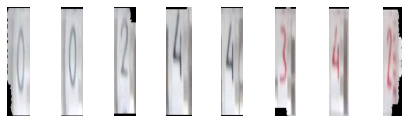

In [428]:
fig, ax = plt.subplots(1, len(chars), figsize=(7.5, 2))
pth = r"C:\Users\Anton\Downloads\TlkWaterMeters\presentation"
for idx, char in enumerate(chars):
    w = len(char[0])
    non_zeros_n = np.count_nonzero(char, axis=1)
    char = char[np.where(non_zeros_n >= 0.5*w)[0]]
    
    ax[idx].imshow(char)
    ax[idx].axis('off')
    cv2.imwrite(os.path.join(pth, str(idx)+".jpg"), char)

In [429]:
images_data = []

for image in chars:
    img = cv2.resize(image, (28, 28))
    images_data.append(img)

images_data = np.array(images_data, dtype=np.uint8)

In [430]:
images_data = [transform_p(img) for img in images_data]

In [431]:
chars_loader = torch.utils.data.DataLoader(images_data, batch_size=8, shuffle=False)

In [432]:
model_recognizer = CNN(output_size=10, dropout=0.5)
model_recognizer.load_state_dict(torch.load("best-state.pt"))

<All keys matched successfully>

In [433]:
y_pred = prediction(model_recognizer, chars_loader)

In [434]:
y_pred

tensor([0, 9, 9, 4, 4, 4, 2, 7])

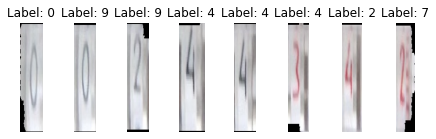

In [435]:
fig, ax = plt.subplots(1, len(chars), figsize=(7.5, 2))
pth = r"C:\Users\Anton\Downloads\TlkWaterMeters\presentation"
for idx, char in enumerate(chars):
    w = len(char[0])
    non_zeros_n = np.count_nonzero(char, axis=1)
    char = char[np.where(non_zeros_n >= 0.5*w)[0]]
    
    ax[idx].imshow(char)
    ax[idx].set_title("Label: {}".format(int(y_pred[idx])))
    ax[idx].axis('off')
    cv2.imwrite(os.path.join(pth, str(idx)+".jpg"), char)